En primer lugar se len los datos del archivo, corrigiendo el formato de separacion, de ';' a ','.

In [1]:
import pandas as pd

raw_dataset = pd.read_csv('Calidad_de_agus_2023.csv', delimiter=';')

raw_dataset

,orden,sitios,codigo,fecha,año,campaña,tem_agua,tem_aire,od,ph,...,dbo_mg_l,dqo_mg_l,turbiedad_ntu,hidr_deriv_petr_ug_l,cr_total_mg_l,cd_total_mg_l,clorofila_a_ug_l,microcistina_ug_l,ica,calidad_de_agua
0,1,Canal Villanueva y Río Luján,TI001,22/2/2023,2023,Verano,26,24,6.59,7.24,...,<2.0,<30,29,<0.10,<0.005,<0.001,0.87,<0.15,53,Muy deteriorada
1,1,Canal Villanueva y Río Luján,TI001,10/5/2023,2023,otoño,18,12,7.09,7.22,...,<2.0,<30,45.00,<0.10,<0.005,<1.0,2.56,<0.15,39,Extremadamente deteriorada
2,1,Canal Villanueva y Río Luján,TI001,23/8/2023,2023,invierno,16.3,11,8.53,7.27,...,<2.0,<30,38,<0.10,<0.005,<0.001,1.02,<0.15,48,Muy deteriorada
3,1,Canal Villanueva y Río Luján,TI001,14/11/2023,2023,primavera,23,25,4.72,6.57,...,<2.0,<30,24,<0.10,<0.005,<0.001,<10.00,<0.15,42,Extremadamente deteriorada
4,2,Río Lujan y Arroyo Caraguatá,TI006,22/2/2023,2023,Verano,26.8,25,5.94,6.96,...,2.1,<30,24,<0.10,<0.005,<0.001,10.61,0.21,39,Extremadamente deteriorada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,42,Balneario Municipal,BS094,23/8/2023,2023,invierno,12,13,9.41,8.67,...,2.3,66,75,<0.10,<0.005,<0.001,19.25,<0.15,36,Extremadamente deteriorada
165,42,Playa La Balandra,BS093,22/2/2023,2023,Verano,20,23,5.8,7.47,...,3.4,58,17,<0.10,<0.005,<0.001,<0.10,>5.00,no se pudo calcular,NaN
166,42,Playa La Balandra,BS093,10/5/2023,2023,otoño,18,13,5.93,8.35,...,2.10,<30,32.00,<0.10,<0.005,<1.0,54.87,<0.15,36,Extremadamente deteriorada
167,42,Playa La Balandra,BS093,14/11/2023,2023,primavera,20,14,8.22,8.30,...,<2.0,48,110,<0.10,0,<0.001,37.4,<0.15,35,Extremadamente deteriorada


Hacemos un head para ver de que tratan los datos.

In [2]:
raw_dataset.head()

,orden,sitios,codigo,fecha,año,campaña,tem_agua,tem_aire,od,ph,...,dbo_mg_l,dqo_mg_l,turbiedad_ntu,hidr_deriv_petr_ug_l,cr_total_mg_l,cd_total_mg_l,clorofila_a_ug_l,microcistina_ug_l,ica,calidad_de_agua
0,1,Canal Villanueva y Río Luján,TI001,22/2/2023,2023,Verano,26,24,6.59,7.24,...,<2.0,<30,29,<0.10,<0.005,<0.001,0.87,<0.15,53,Muy deteriorada
1,1,Canal Villanueva y Río Luján,TI001,10/5/2023,2023,otoño,18,12,7.09,7.22,...,<2.0,<30,45.00,<0.10,<0.005,<1.0,2.56,<0.15,39,Extremadamente deteriorada
2,1,Canal Villanueva y Río Luján,TI001,23/8/2023,2023,invierno,16.3,11,8.53,7.27,...,<2.0,<30,38,<0.10,<0.005,<0.001,1.02,<0.15,48,Muy deteriorada
3,1,Canal Villanueva y Río Luján,TI001,14/11/2023,2023,primavera,23,25,4.72,6.57,...,<2.0,<30,24,<0.10,<0.005,<0.001,<10.00,<0.15,42,Extremadamente deteriorada
4,2,Río Lujan y Arroyo Caraguatá,TI006,22/2/2023,2023,Verano,26.8,25,5.94,6.96,...,2.1,<30,24,<0.10,<0.005,<0.001,10.61,0.21,39,Extremadamente deteriorada


Borramos las columas orden, codigo y año ya que no aportan nada al analisis.

In [3]:
raw_dataset = raw_dataset.drop('orden', axis=1)
raw_dataset = raw_dataset.drop('codigo', axis=1)
raw_dataset = raw_dataset.drop('año', axis=1)


Ahora en busca de nulos por columna.

In [4]:
raw_dataset.isna().sum()

sitios                      0
fecha                       0
campaña                     0
tem_agua                    0
tem_aire                    0
od                          0
ph                          1
olores                      0
color                       0
espumas                     0
mat_susp                    0
colif_fecales_ufc_100ml     0
escher_coli_ufc_100ml       0
enteroc_ufc_100ml           0
nitrato_mg_l                0
nh4_mg_l                    0
p_total_l_mg_l              1
fosf_ortofos_mg_l           0
dbo_mg_l                    1
dqo_mg_l                    0
turbiedad_ntu               0
hidr_deriv_petr_ug_l        0
cr_total_mg_l               0
cd_total_mg_l               0
clorofila_a_ug_l            0
microcistina_ug_l           0
ica                         1
calidad_de_agua            15
dtype: int64

Vemos en cada una de las columnas que valores toman.

In [5]:
#se revisa una por una las columnas
#lo que esta entre corchetes se fue cambiando entre todas las variables para ver que valores aparecen

for idx, val in raw_dataset["od"].value_counts().items():
  print(idx, val)

sin equipo 12
no muestreó 7
no se midió 5
en obra 4
no se muestreó 4
6.3 3
6.4 2
5.4 2
8.53 2
5.94 2
7.60 2
N/R 2
6.33 2
inaccesible 2
5.85 2
5.02 2
7.09 1
6.59 1
5.36 1
2.01 1
5.26 1
4.13 1
2.67 1
3.45 1
5.88 1
3.1 1
1.95 1
6.7 1
6.16 1
6.14 1
6.88 1
2.62 1
4.72 1
7.12 1
7.74 1
7.82 1
5.19 1
4.15 1
8.72 1
8.09 1
6.5 1
5.65 1
5.61 1
5.16 1
6.66 1
6.69 1
3.24 1
6.32 1
7.64 1
2.94 1
8.27 1
4.86 1
6.37 1
6.60 1
5.20 1
8.15 1
6.95 1
6.79 1
7.41 1
4.88 1
4.31 1
5.97 1
6.08 1
5.75 1
2.98 1
5.28 1
2.20 1
5.14 1
5.07 1
8 1
5.57 1
5.58 1
0.6 1
3.03 1
3.33 1
1.2 1
5.22 1
4.85 1
4.99 1
5.24 1
7.9 1
6.20 1
0.96 1
1.22 1
1.99 1
3.02 1
3.22 1
1.1 1
2.64 1
4.45 1
6.82 1
5.55 1
9.88 1
5.70 1
9.3 1
7.23 1
3.55 1
8.4 1
11.49 1
8.11 1
7.13 1
12.62 1
8.28 1
2.68 1
4.24 1
8.44 1
5.48 1
8.57 1
6.13 1
5.63 1
7.43 1
0.2 1
6.24 1
9.05 1
4.76 1
8.99 1
5.92 1
11.70 1
7.51 1
6.65 1
10.88 1
4.53 1
7.53 1
10.02 1
9.78 1
9.41 1
5.8 1
5.93 1
8.22 1
8.96 1


Remplazamos por nulos los valores que no nos interesan, es decir, no nos aportan informacion relevante.

In [6]:
import pandas as pd

# Copiar el dataset
preprocessed_dataset = raw_dataset.copy()

# Lista de valores a reemplazar por pd.NA
valores_a_reemplazar = ['sin equipo', 'no muestreó', 'no se midió', 'en obra', 'no se muestreó',
                        'inaccesible', 'sin muestra', 'envase sin muestra', 'falto un frasco',
                        'Dato atípico', 'no se pudo calcular', 'N/R', 'no funcionó', '-', 'N/A', '', ' ']

# Lista de columnas a las que se les debe aplicar el reemplazo
columnas_a_procesar = [
    'tem_agua', 'tem_aire', 'od', 'ph', 'olores', 'color', 'espumas', 'mat_susp', 
    'colif_fecales_ufc_100ml', 'escher_coli_ufc_100ml', 'enteroc_ufc_100ml', 
    'nitrato_mg_l', 'nh4_mg_l', 'p_total_l_mg_l', 'fosf_ortofos_mg_l', 
    'dbo_mg_l', 'dqo_mg_l', 'turbiedad_ntu', 'hidr_deriv_petr_ug_l', 'cr_total_mg_l',
    'cd_total_mg_l', 'clorofila_a_ug_l', 'microcistina_ug_l', 'ica', 'calidad_de_agua'
]

# Recorrer todas las columnas y aplicar el reemplazo
for columna in columnas_a_procesar:
    preprocessed_dataset[columna] = preprocessed_dataset[columna].replace(valores_a_reemplazar, pd.NA)


Ahora vamos a borrar aquellas filas que quedaron con muchos nulos, ya que no nos van a servir para el analisis. Estas filas borradas son aquellas con mas de 23 valores nulos, que corresponden a las muestras donde no se realizaron observaciones.

In [7]:

preprocessed_dataset = preprocessed_dataset.dropna(thresh=len(preprocessed_dataset.columns) - 23)

Luego definimos las columnas que van a ser de tipo cuantitativos y de fecha, eliminando los simbolos "<" o ">" en los valores que los porten.

In [8]:
columnas_a_convertir = ['tem_agua', 'tem_aire', 'od', 'ph', 'colif_fecales_ufc_100ml',
                         'escher_coli_ufc_100ml', 'enteroc_ufc_100ml', 'nitrato_mg_l', 'nh4_mg_l',
                         'p_total_l_mg_l', 'fosf_ortofos_mg_l', 'dbo_mg_l', 'dqo_mg_l', 'turbiedad_ntu',
                         'hidr_deriv_petr_ug_l', 'cr_total_mg_l', 'cd_total_mg_l', 'clorofila_a_ug_l',
                         'microcistina_ug_l', 'ica']

for col in columnas_a_convertir:
    preprocessed_dataset[col] = preprocessed_dataset[col].str.replace('<', '').str.replace('>', '')
    preprocessed_dataset[col] = pd.to_numeric(preprocessed_dataset[col])

preprocessed_dataset['fecha'] = pd.to_datetime(preprocessed_dataset['fecha'], format="%d/%m/%Y")

Transformamos el tipo de dato de determinadas columnas para poder trabajar con las variables cualitativas.

In [9]:
#Transformacion campaña
preprocessed_dataset['campaña']=preprocessed_dataset['campaña'].replace(['Verano','otoño','invierno','primavera'],['0','1','2','3'])

#transformacion olores, color, espumas,mat_susp
preprocessed_dataset['olores']=preprocessed_dataset['campaña'].replace(['Ausencia','Presencia'],['0','1'])
preprocessed_dataset['color']=preprocessed_dataset['color'].replace(['Ausencia','Presencia'],['0','1'])
preprocessed_dataset['espumas']=preprocessed_dataset['espumas'].replace(['Ausencia','Presencia'],['0','1'])
preprocessed_dataset['mat_susp']=preprocessed_dataset['mat_susp'].replace(['Ausencia','Presencia'],['0','1'])

#transformacion calidad_de_agua
preprocessed_dataset['calidad_de_agua']=preprocessed_dataset['calidad_de_agua'].replace(['Muy deteriorada','Muy deteriorada ','Extremadamente deteriorada'],['0','0','1'])

columnas_cualitativas = ['campaña', 'olores', 'color', 'espumas', 'mat_susp', 'calidad_de_agua']
preprocessed_dataset[columnas_cualitativas] = preprocessed_dataset[columnas_cualitativas].apply(pd.to_numeric, errors='coerce')

Analizamos el porcentaje de nulos en cada columna para ver si las eliminabamos. Como en ninguna de las columnas hay presencia de nulos mayor o igual al 60% las conservamos.

In [10]:
columnas_totales = columnas_a_convertir.copy()
columnas_totales.extend(columnas_cualitativas)

for col in columnas_totales:
    if ((preprocessed_dataset[col].isna().sum() / len(preprocessed_dataset[col]))*100 >= 60):
        print(col)

De acuerdo a la columna, realizamos imputaciones con la tecnica de los n vecinos mas cercanos, eligiendo los dos mas cercanos, para suprimir los valores nulos restantes.

No sabemos si esto es correcto al no haber analizado los mecanismos de datos faltantes, por desconcer el dominio del problema.

In [11]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors = 2, weights = "uniform")


preprocessed_dataset_imputado = preprocessed_dataset[columnas_totales]
dataset_imputado = imputer.fit_transform(preprocessed_dataset_imputado)

preprocessed_dataset[columnas_totales] = dataset_imputado

Veamos las correlaciones entre los datos ya preprocesados, a ver si vemos algo que supera nuestra regla del pulgar de 0.7 en coeficiente de correlacion (numero elegido por conveniencia). Para estas correlaciones los stios y fechas no los consideramos al no ser valores numericos.

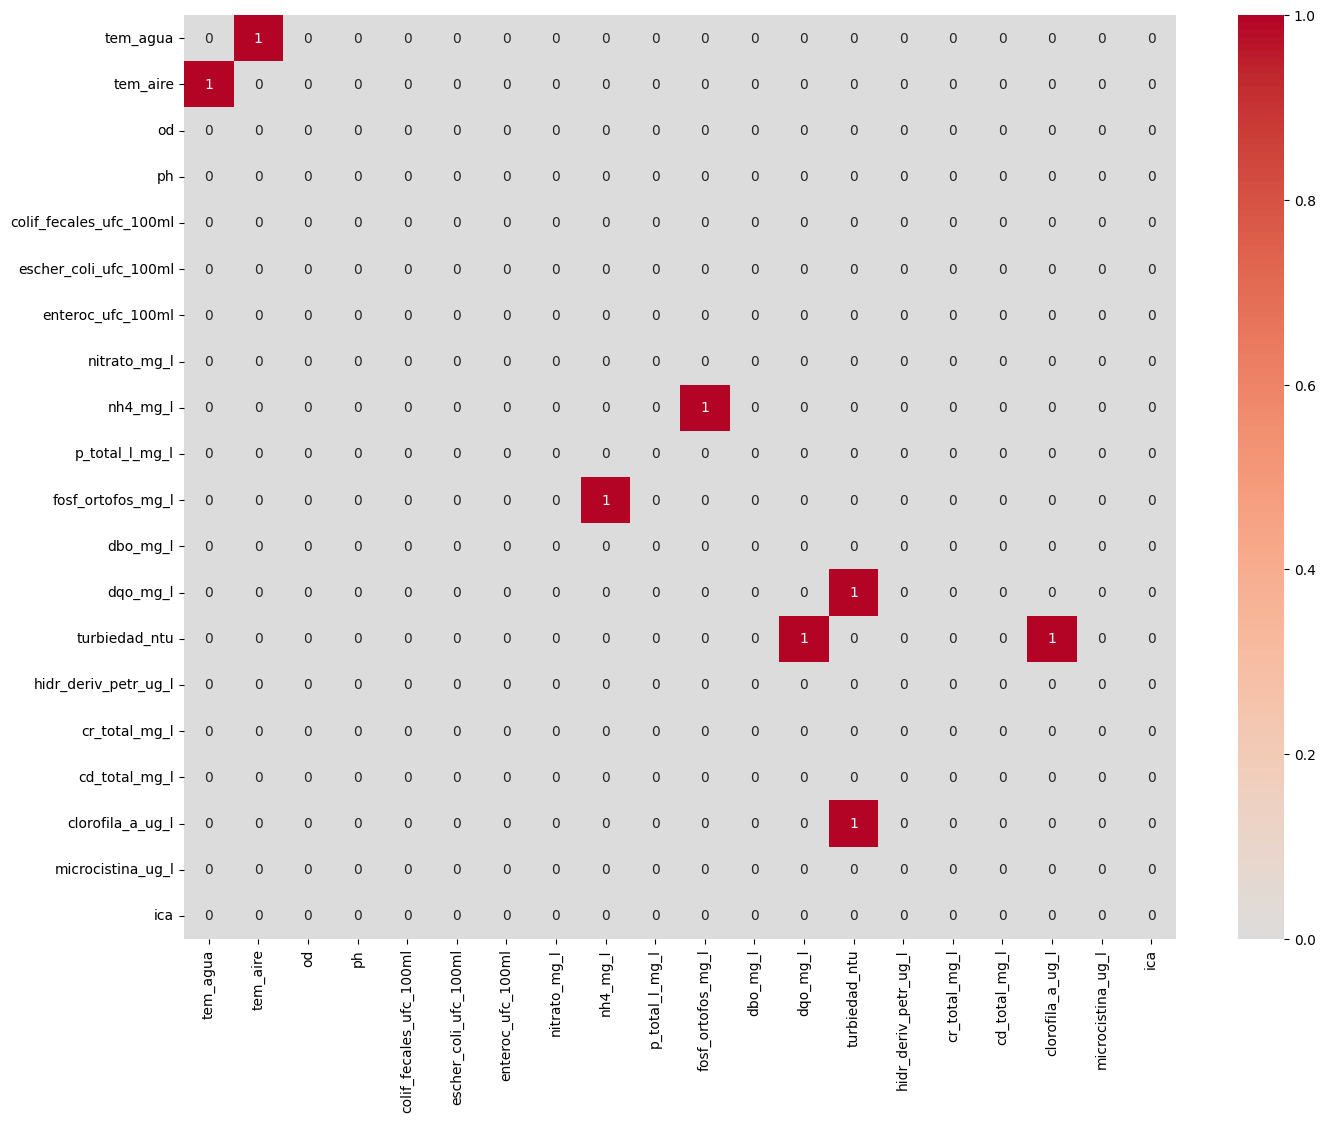

In [13]:
cosas = ['sitios','fecha']
preprocessed_dataset_a = preprocessed_dataset.drop(cosas, axis = 1)
preprocessed_dataset_a = preprocessed_dataset_a.drop(columnas_cualitativas, axis = 1)

correlation_matrix = preprocessed_dataset_a.corr()

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# tomamos el valor absoluto de las correlaciones, umbralamos las mayores a 0.7
correlation_matrix_umbralizada = correlation_matrix.abs() > 0.7
# aprovechamos y sacamos la diagonal
np.fill_diagonal(correlation_matrix_umbralizada.values, 0)

# e imprimimos la matriz como un heatmap
plt.figure(figsize=(16,12))
sns.heatmap(correlation_matrix_umbralizada, vmin=0.0, vmax=1.0, center=0.0, annot=True, cmap= 'coolwarm')
plt.show()

Como vemos, tenemos correlaciones con coeficiente superior o igual al valor esperado entre: 

- Temperatura del agua y temperatura del aire.

- Concentracion de ortofosfatos en miligramos por ml y concentracion de amoniaco en miligramos por ml.

- Turbidez del agua y clorofila en microgramos por litro.

- Turbidez del agua y demanda qimica de oxigeno en miligramos por ml.

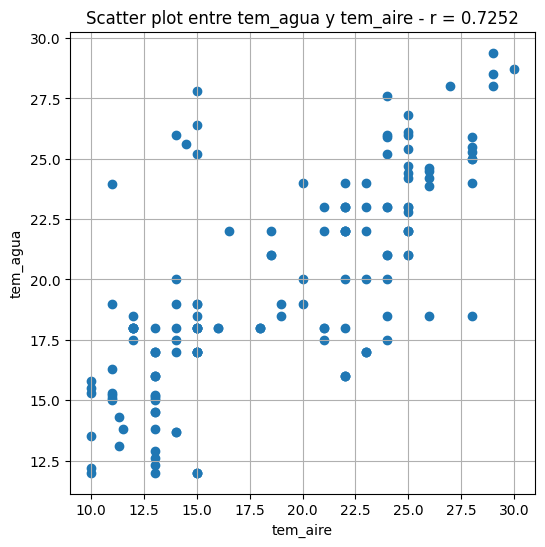

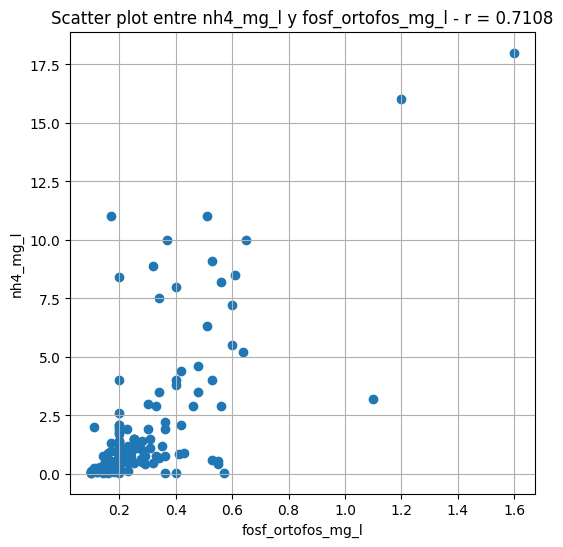

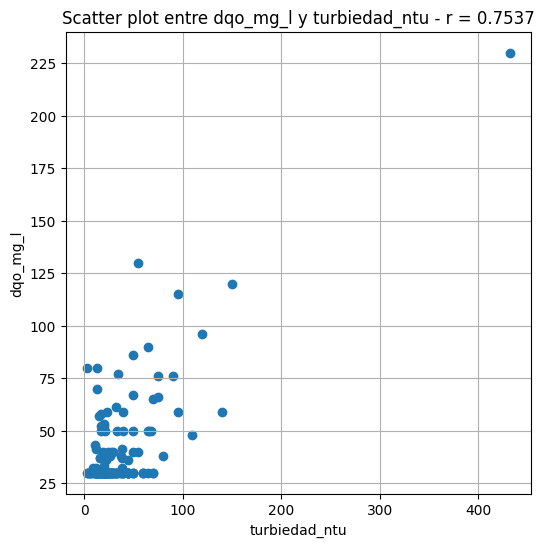

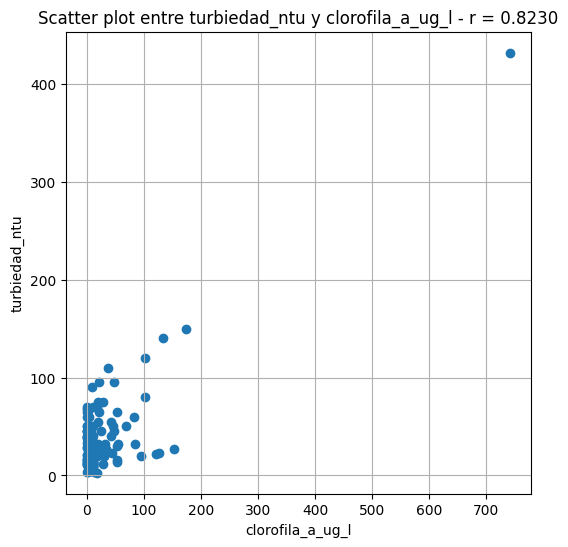

In [15]:
# iteramos por cada una de las columnas
for i, col in enumerate(correlation_matrix_umbralizada.columns):
  # y por cada una de las filas (para eso usamos el índice)
  for j in range(i,len(correlation_matrix_umbralizada.index)):
    # extraemos el nombre de la fila en la que estamos
    row = correlation_matrix_umbralizada.index[j]
    # si en esa posición tenemos un True en la matriz umbralizada
    if correlation_matrix_umbralizada.loc[row, col]:
      # nos traemos el valor de esa correlación
      correlation = correlation_matrix.loc[row, col]
      # representamos en un scatter plot cuadrado los valores de ambas variables
      plt.figure(figsize=(6, 6))
      plt.scatter(preprocessed_dataset[row], preprocessed_dataset[col])
      # y lo mostramos bonito
      plt.title(f"Scatter plot entre {col} y {row} - r = {correlation:.4f}")
      plt.xlabel(row)
      plt.ylabel(col)
      plt.grid(True)
      plt.show()

Vemos unos posibles outliers en los scatter plots, veamos si se confirma esto.

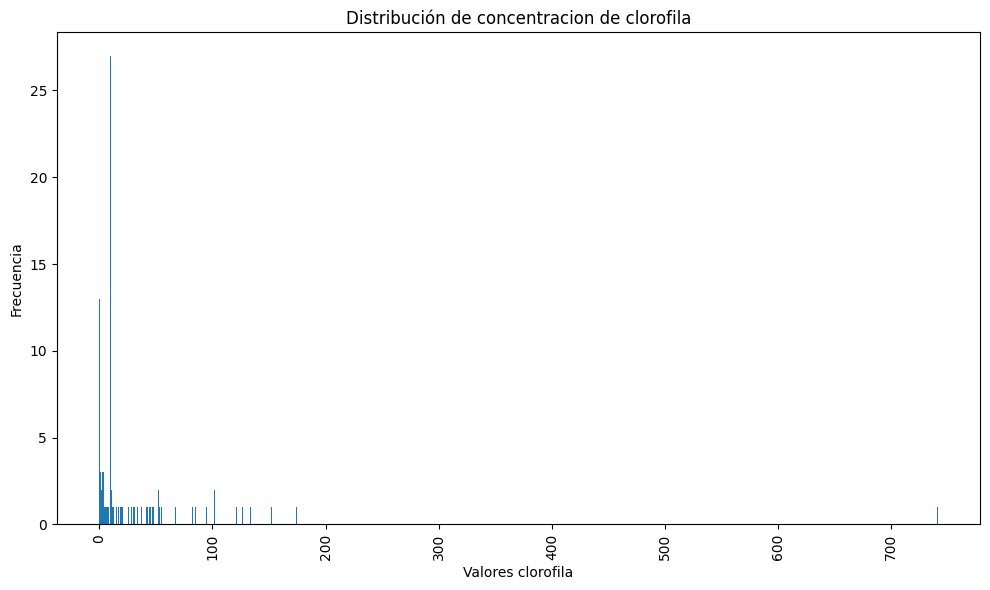

In [26]:
# contamos las frecuencias de cada valor
industry_counts = preprocessed_dataset['clorofila_a_ug_l'].value_counts()

# ordenamos las frecuencias de mayor a menor
industry_counts = industry_counts.sort_values(ascending=False)

# graficamos el histograma
plt.figure(figsize=(10, 6))  # Ajusta el tamaño de la figura si es necesario
plt.bar(industry_counts.index, industry_counts.values)
plt.xticks(rotation=90)  # Rota las etiquetas del eje x para mayor legibilidad
plt.xlabel('Valores clorofila')
plt.ylabel('Frecuencia')
plt.title('Distribución de concentracion de clorofila')
plt.tight_layout()  # Ajusta el diseño para evitar superposiciones
plt.show()


Vemos un claro outlier que tiene una concentracion de 740 de clorofila

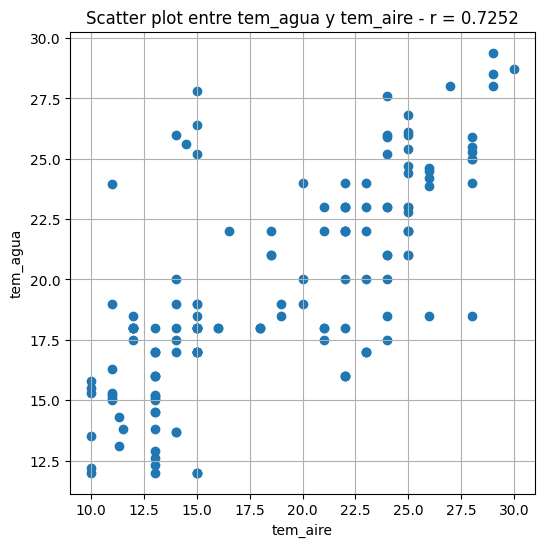

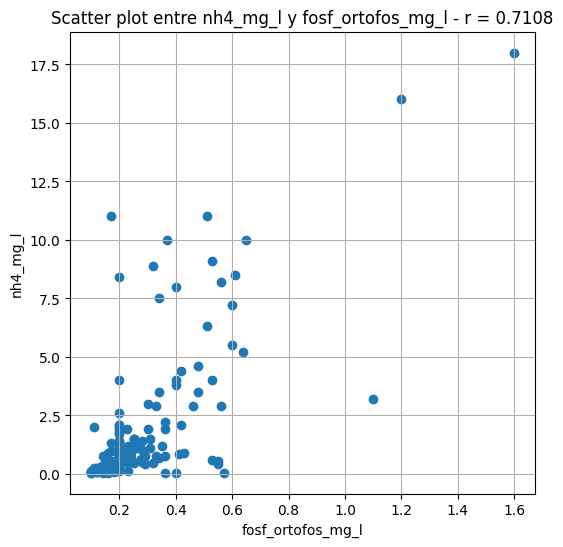

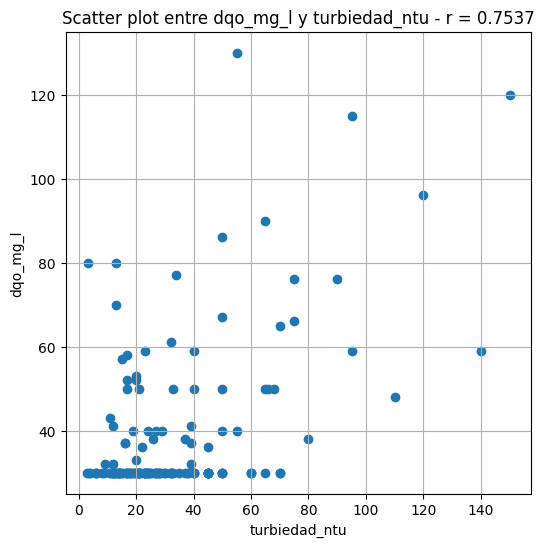

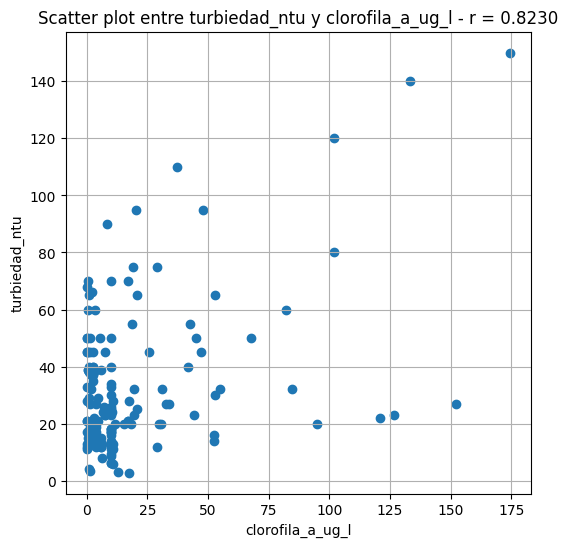

In [47]:
preprocessed_dataset = preprocessed_dataset.drop(preprocessed_dataset[preprocessed_dataset['clorofila_a_ug_l']> 700].index)

# iteramos por cada una de las columnas
for i, col in enumerate(correlation_matrix_umbralizada.columns):
  # y por cada una de las filas (para eso usamos el índice)
  for j in range(i,len(correlation_matrix_umbralizada.index)):
    # extraemos el nombre de la fila en la que estamos
    row = correlation_matrix_umbralizada.index[j]
    # si en esa posición tenemos un True en la matriz umbralizada
    if correlation_matrix_umbralizada.loc[row, col]:
      # nos traemos el valor de esa correlación
      correlation = correlation_matrix.loc[row, col]
      # representamos en un scatter plot cuadrado los valores de ambas variables
      plt.figure(figsize=(6, 6))
      plt.scatter(preprocessed_dataset[row], preprocessed_dataset[col])
      # y lo mostramos bonito
      plt.title(f"Scatter plot entre {col} y {row} - r = {correlation:.4f}")
      plt.xlabel(row)
      plt.ylabel(col)
      plt.grid(True)
      plt.show()